In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
import lightgbm as lgb
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
import datetime as dt

In [2]:
#Load data: Load both the merged data and the original unaltered data 
merged_file = '../DataSet/merged_data2.csv'
data = pd.read_csv(merged_file, parse_dates =[2])

#market_file = '../DataSet/market_clean.csv'
#data = pd.read_csv(market_file, parse_dates =[1])

#news_file = '../DataSet/news_train_df.csv'
#news_data = pd.read_csv(news_file, parse_dates =[1])

In [3]:
#Eliminate recession data
data = data[data.time >= '2010-1-1']

# Word Embedding Using Subjects and Headlines

In [4]:
#Eliminate headlineTage and remove all rows without headline data
data = data.drop('headlineTag', axis = 1)
data = data.fillna(0)
data = data[data.headline != 0]
data = data.reset_index()

In [11]:
#Vectorize the subject lines and then perform svd on them to create new features
vectorizer = CountVectorizer()
vectorizer.fit(data.subjects)

X_subjects = vectorizer.transform(data.subjects)

n_comp = 10

svd = TruncatedSVD(n_components = n_comp)
svd.fit(X_subjects)
X_svd = svd.transform(X_subjects)
tempmat = pd.SparseDataFrame(X_svd)

for index in range(n_comp):
    name = 'subject_' + str(index)
    data[name] = tempmat.iloc[:,index]

var_subject = svd.explained_variance_ratio_
del vectorizer, svd, X_svd, tempmat

In [12]:
X_subjects.shape

(4155955, 1552)

In [9]:
#Vectorize the headlines and then perform svd on them to create new features
vectorizer = CountVectorizer()
vectorizer.fit(data.headline)

X_subjects = vectorizer.transform(data.headline)

n_comp = 10

svd = TruncatedSVD(n_components = n_comp)
svd.fit(X_subjects)
X_svd = svd.transform(X_subjects)
tempmat = pd.SparseDataFrame(X_svd)

for index in range(n_comp):
    name = 'headline_' + str(index)
    data[name] = tempmat.iloc[:,index]
    
var_headline = svd.explained_variance_ratio_
del vectorizer, svd, X_svd, tempmat

In [10]:
X_subjects.shape

(4155955, 167317)

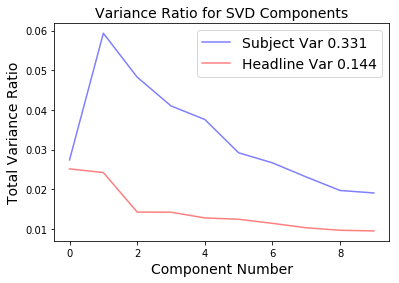

In [8]:
#Graph explained variance ratio for subject and headline svd components.
x_vec = range(len(var_headline))
var_s = var_subject.sum()
var_h = var_headline.sum()

plt.plot(x_vec, var_subject, color = 'b', alpha = 0.5)
plt.plot(x_vec, var_headline, color = 'r', alpha = 0.5)
plt.xlabel('Component Number', fontsize = 14)
plt.ylabel('Total Variance Ratio', fontsize = 14)
plt.title('Variance Ratio for SVD Components', fontsize = 14)
plt.legend(['Subject Var %.3f'%var_s, 'Headline Var %.3f'%var_h], loc = 'upper right', fontsize = 14)
plt.savefig('VarianceRatio_embed_av.png', bbox = 'tight')
plt.show()

In [7]:
#Combine mean of news data information by day
data = data.groupby(['assetName','time']).mean()
data = data.reset_index(drop = False)

In [8]:
#Save compact data to file
compact_file = '../DataSet/compact_data_embed.csv'
data.to_csv(compact_file)

In [2]:
#Load saved compact data
compact_file = '../DataSet/compact_data_embed.csv'
data = pd.read_csv(compact_file,  parse_dates =[2])

# Feature Engineering

In [3]:
#Create new features to help in modeling data

#Calculate asset name values
array_idx = dict(zip(data.assetName.unique(), np.arange(data.assetName.nunique())))
data['assetNameT'] = data['assetName'].map(array_idx)

#Calculate a rolling average of 5 and 10 days over the stock opening price
open5 = data.groupby('assetName')['open'].rolling(window = 5).mean()
open10 = data.groupby('assetName')['open'].rolling(window = 10).mean()

#Calculate daily log return
logr = np.log10(data.close/data.open)

#Return Prev10 Raw rolling average over 5 and 10 days
r5 = data.groupby('assetName')['returnsOpenPrevRaw10'].rolling(window = 5).mean()
r10 = data.groupby('assetName')['returnsOpenPrevRaw10'].rolling(window = 10).mean()

#Sentiment class average over 5 and 10 data points
sent5 = data.groupby('assetName')['sentimentClass'].rolling(window = 5).mean()
sent10 = data.groupby('assetName')['sentimentClass'].rolling(window = 10).mean()

#Insert data into dataframe for use in modeling
data['open5'] = open5.values
data['open10'] = open10.values
data['r5'] = r5.values
data['r10'] = r10.values
data['logr'] = logr
data['sent5'] = sent5.values
data['sent10'] = sent10.values

In [10]:
#data = data.drop(['assetCode', 'assetName', 
 #              'sourceTimestamp', 'firstCreated', 'sourceId', 
 #              'provider', 'subjects', 'audiences', 'assetCodes', 
  #             'Unnamed: 0', 'Unnamed: 0.1', 'marketCommentary', 'headline'], axis = 1)
#['assetCode', 'assetName', 
#               'sourceTimestamp', 'firstCreated', 'sourceId', 
#               'provider', 'subjects', 'audiences', 'assetCodes', 
#               'Unnamed: 0', 'Unnamed: 0.1', 'marketCommentary', 'headline']

In [5]:
#Set up X and y for modeling
X = data.drop(['marketCommentary', 'Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1',
            'bodySize', 'companyCount'], axis = 1)
X = X.dropna(axis = 0)
y = (X.returnsOpenNextMktres10 >= 0)
y = y.astype(int)

#Set up additional parameters to calculate final metric used in Two Sigma competition
universe = X.dropna(axis = 0).universe
r = X.dropna(axis = 0).returnsOpenNextMktres10
day = X.dropna(axis = 0).time.dt.date
asset_name = X.dropna(axis = 0).assetName

X = X.drop(['returnsOpenNextMktres10', 'universe', 'time', 'assetName'], axis = 1)

In [6]:
#Create train and test sets
X_train, X_test, y_train, y_test, _, univ_test, _, r_test, _, day_test, _, asset_test = \
       train_test_split(X, y, universe, r, day, asset_name, test_size = 0.3, random_state = 42)
del X, y, universe, r, day

In [13]:
print(len(y_train))
print(len(y_test))

527878
226234


In [7]:
#Print out final feature list used for modeling
print(X_train.columns)

Index(['close', 'firstMentionSentence', 'headline_0', 'headline_1',
       'headline_2', 'headline_3', 'headline_4', 'headline_5', 'headline_6',
       'headline_7', 'headline_8', 'headline_9', 'index', 'noveltyCount12H',
       'noveltyCount24H', 'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D',
       'open', 'relevance', 'returnsClosePrevMktres1',
       'returnsClosePrevMktres10', 'returnsClosePrevRaw1',
       'returnsClosePrevRaw10', 'returnsOpenPrevMktres1',
       'returnsOpenPrevMktres10', 'returnsOpenPrevRaw1',
       'returnsOpenPrevRaw10', 'sentenceCount', 'sentimentClass',
       'sentimentNegative', 'sentimentNeutral', 'sentimentPositive',
       'sentimentWordCount', 'subject_0', 'subject_1', 'subject_2',
       'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7',
       'subject_8', 'subject_9', 'takeSequence', 'urgency', 'volume',
       'volumeCounts12H', 'volumeCounts24H', 'volumeCounts3D',
       'volumeCounts5D', 'volumeCounts7D', 'wordCount', 'asse

# XGBoost Classifier

In [8]:
#Set up model and determine best parameters for XGBClassifier
#params = {'n_estimators': [200, 500, 1000, 2000, 4000],
#          'max_depth': [4, 6, 8, 10],
#          'learning_rate': [.001, .01, 0.1, 0.3],
#          'booster': ['gbtree', 'gblinear', 'dart']}
params = {'booster': 'gbtree',
          'learning_rate': 0.1,
          'max_depth': 6,
           'n_estimators': 100,
          'n_jobs': 4}
#gb_cv = GridSearchCV(gb, params, cv = 5, n_jobs = -1)

#Preform grid search to find best fit parameters using XGBClassifier
#gb_cv.fit(X_train, y_train)

#Show the best parameters and best score value determined from the grid search
#print(gb_cv.best_params_)
#print(gb_cv.best_score_)

In [7]:
#Initialize model with optimized parameters
model = XGBClassifier(**params)

In [8]:
%%time
#Fit model to training data
gb_model = model.fit(X_train, y_train)

Wall time: 3min 17s


In [9]:
#Collection prediction values for classification
y_pred = model.predict_proba(X_test)
predictions = [round(value[1]) for value in y_pred]

In [16]:
#Calculate accuracy score for the predictions
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %.4f'%(accuracy))

Accuracy: 0.5867


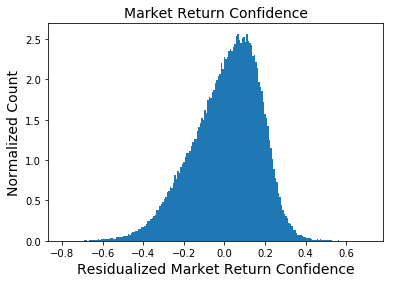

In [17]:
#Plot histogram of prediction results.  Notice, using the Two Sigma scoring metric to calculate the 
#conifidence that returnOpenNextMktres10 is negative or positive.
y_r = y_pred[:,1]*2 - 1
plt.hist(y_r, bins = 'auto', density = True)
plt.xlabel('Residualized Market Return Confidence', fontsize = 14)
plt.ylabel('Normalized Count', fontsize = 14)
plt.title('Market Return Confidence', fontsize = 14)
plt.savefig('ReturnConfidence_embed_av.png', bbox = 'tight')
plt.show()

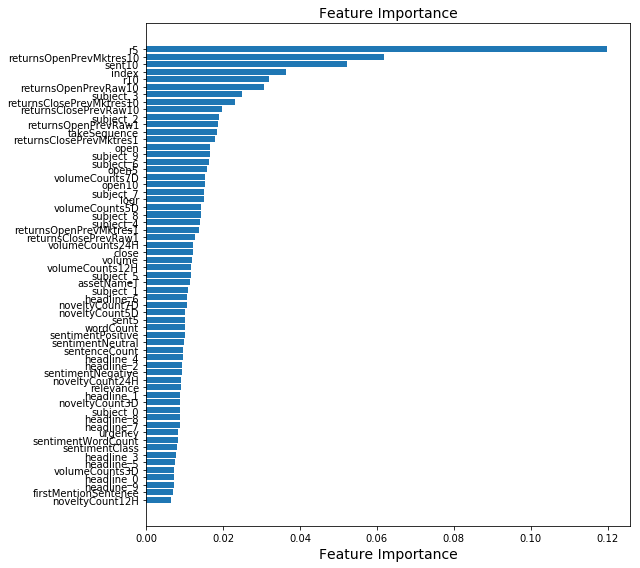

In [18]:
#Display bar graph of feature importance in model
features = X_train.columns
feat_imp = model.feature_importances_
feat = pd.DataFrame()
feat['feature'] = features
feat['importance'] = feat_imp
feat = feat.sort_values('importance')

wide = np.arange(len(feat_imp))
plt.figure(figsize = (9,8))
plt.barh(wide, feat['importance'])
plt.yticks(wide, feat['feature'])
plt.xlabel('Feature Importance', fontsize = 14)
plt.title('Feature Importance', fontsize = 14)
plt.tight_layout()
plt.savefig('FeatureImportance_embed_av.png', bbox = 'tight')
plt.show()

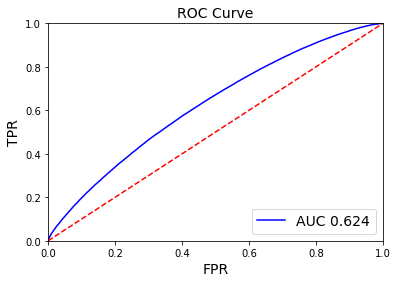

In [19]:
#Plot ROC curve for XGBClassifier model
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
auc = roc_auc_score(y_test, y_pred[:,1])

plt.plot(fpr, tpr, color = 'blue')
plt.plot([0,1], [0,1], color = 'red', linestyle = '--')
plt.xlabel('FPR', fontsize = 14)
plt.ylabel('TPR', fontsize = 14)
plt.title('ROC Curve', fontsize = 14)
plt.axis([0, 1, 0, 1])
plt.legend(['AUC %.3f'%auc], loc = 'lower right', fontsize = 14)
plt.savefig('ROC_XGBClassifier_embed_av.png', bbox = 'tight')
plt.show()

In [9]:
#Calculate the metric used Two Sigma competition for scoring
def two_sigma_score(y_r, univ_test, r_test):
    #Clip outliers for the returnsOpenNextMktres10 data
    r_test2 = r_test.clip(-1,1)
    
    #Calculate scoring metric
    y_int = y_r*univ_test*r_test2
    df = pd.DataFrame()

    df['day'] = day_test[y_int != 0]
    df['y_int'] = y_int[y_int != 0]

    y_i = df.groupby('day').sum().values.flatten()
    mean_i = np.mean(y_i)
    std_i = np.std(y_i)

    score_ts = mean_i/std_i

    return score_ts

In [21]:
score_gb = two_sigma_score(y_r, univ_test, r_test)
print('Score using XGBClassifier %.4f'%(score_gb))

Score using XGBClassifier 0.9241


# Light GBM Classsification

In [22]:
#Perform light gbm
train_data = lgb.Dataset(X_train, label=y_train)
param = {'num_leaves':100,
         'objective':'binary',
         'max_depth':6,
         'learning_rate':0.1,
         'max_bin':200}

lgb_model = lgb.train(param, train_data, 50)
ypred_lgb = lgb_model.predict(X_test)

In [23]:
predictions2 = [round(value) for value in ypred_lgb]

In [24]:
#Calculate accuracy score for the predictions
accuracy = accuracy_score(y_test, predictions2)
print('Accuracy: %.4f'%(accuracy))

Accuracy: 0.5738


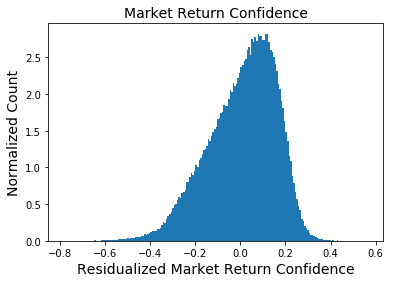

In [25]:
#Plot histogram of prediction results.  Notice, using the Two Sigma scoring metric to calculate the 
#conifidence that returnOpenNextMktres10 is negative or positive.
y_r = ypred_lgb*2 - 1
plt.hist(y_r, bins = 'auto', density = True)
plt.xlabel('Residualized Market Return Confidence', fontsize = 14)
plt.ylabel('Normalized Count', fontsize = 14)
plt.title('Market Return Confidence', fontsize = 14)
plt.savefig('ReturnConfidence_lgb_embed_av.png', bbox = 'tight')
plt.show()

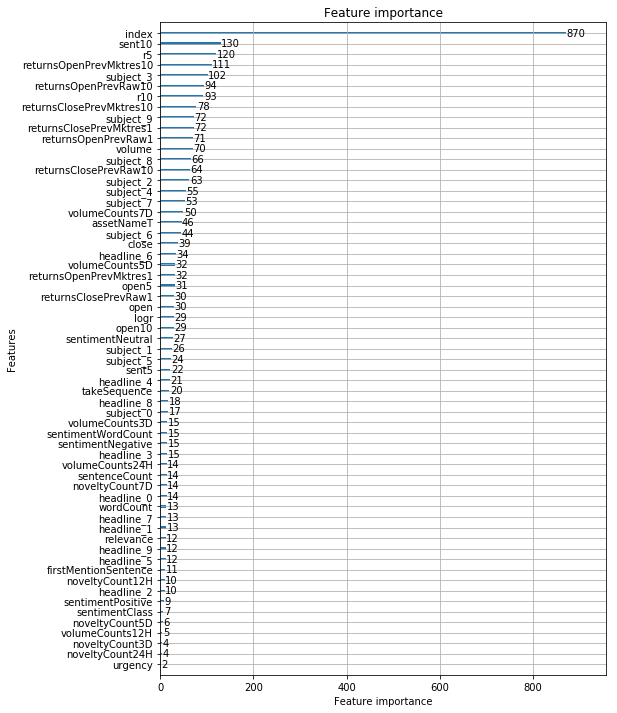

In [26]:
#Display bar graph of feature importance in model
lgb.plot_importance(lgb_model, figsize=(8,12))

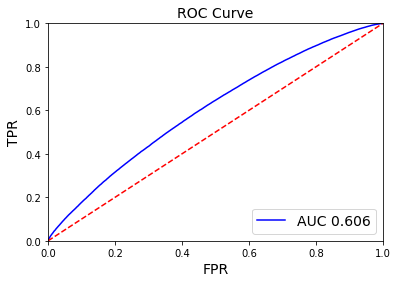

In [49]:
#Calculate ROC curve for light gbm model
fpr, tpr, thresholds = roc_curve(y_test, ypred_lgb)
auc = roc_auc_score(y_test, ypred_lgb)

plt.plot(fpr, tpr, color = 'blue')
plt.plot([0,1], [0,1], color = 'red', linestyle = '--')
plt.xlabel('FPR', fontsize = 14)
plt.ylabel('TPR', fontsize = 14)
plt.title('ROC Curve', fontsize = 14)
plt.axis([0, 1, 0, 1])
plt.legend(['AUC %.3f'%auc], loc = 'lower right', fontsize = 14)
plt.savefig('ROC_XGBClassifier_lgb_embed_av.png', bbox = 'tight')
plt.show()

In [22]:
#Calculate the metric used Two Sigma competition for scoring
y_r = ypred_lgb*2 - 1
score_lb = two_sigma_score(y_r, univ_test, r_test)
print('Score using Light GBM %.4f'%(score_lb))

Score using Light GBM 0.8275


# Naive Bayes Classification

In [23]:
#Perform Naive Bayes algorithm on data
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

In [24]:
#Calculate accuracy score for the predictions
y_pred_nb = nb.predict_proba(X_test)
predictions_nb = [round(value[1]) for value in y_pred_nb]

accuracy = accuracy_score(y_test, predictions_nb)
print('Accuracy: %.4f'%(accuracy))

Accuracy: 0.5052


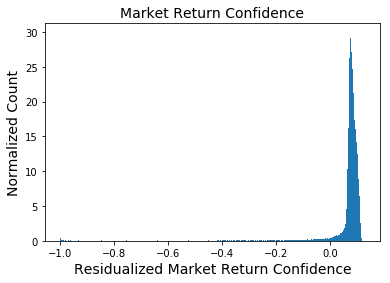

In [54]:
#Plot histogram of prediction results.  Notice, using the Two Sigma scoring metric to calculate the 
#conifidence that returnOpenNextMktres10 is negative or positive.
y_r = y_pred_nb[:,1]*2 - 1
plt.hist(y_r, bins = 'auto', density = True)
plt.xlabel('Residualized Market Return Confidence', fontsize = 14)
plt.ylabel('Normalized Count', fontsize = 14)
plt.title('Market Return Confidence', fontsize = 14)
plt.savefig('ReturnConfidence_nb_embed_av.png', bbox = 'tight')
plt.show()

In [55]:
#Calculate the metric used Two Sigma competition for scoring
score_nb = two_sigma_score(y_r, univ_test, r_test)
print('Score using NB %.4f'%(score_nb))

Score using NB 0.0810


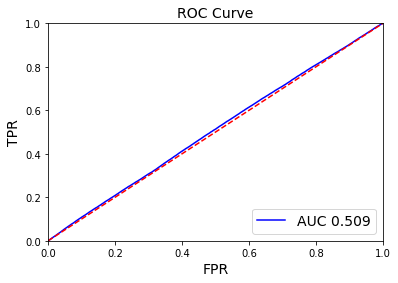

In [52]:
#Calculate ROC curve for NB model
fpr, tpr, thresholds = roc_curve(y_test, y_pred_nb[:,1])
auc = roc_auc_score(y_test, y_pred_nb[:,1])

plt.plot(fpr, tpr, color = 'blue')
plt.plot([0,1], [0,1], color = 'red', linestyle = '--')
plt.xlabel('FPR', fontsize = 14)
plt.ylabel('TPR', fontsize = 14)
plt.title('ROC Curve', fontsize = 14)
plt.axis([0, 1, 0, 1])
plt.legend(['AUC %.3f'%auc], loc = 'lower right', fontsize = 14)
plt.savefig('ROC_XGBClassifier_NB_embed_av.png', bbox = 'tight')
plt.show()

# KNN Classifier 

In [18]:
%%time
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 30)

knn_model = knn.fit(X_train, y_train)

Wall time: 6.01 s


In [19]:
#Collection prediction values for classification
y_knn = knn.predict_proba(X_test)
prediction_knn = [round(value[1]) for value in y_knn]

In [20]:
#Calculate accuracy score for the predictions
accuracy = accuracy_score(y_test, prediction_knn)
print('Accuracy: %.4f'%(accuracy))

Accuracy: 0.5251


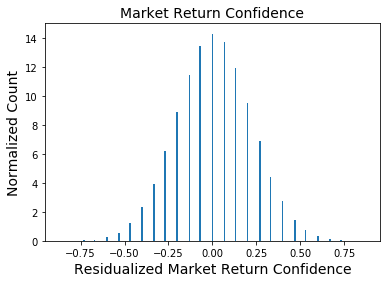

In [21]:
#Plot histogram of prediction results.  Notice, using the Two Sigma scoring metric to calculate the 
#conifidence that returnOpenNextMktres10 is negative or positive.
y_r = y_knn[:,1]*2 - 1
plt.hist(y_r, bins = 'auto', density = True)
plt.xlabel('Residualized Market Return Confidence', fontsize = 14)
plt.ylabel('Normalized Count', fontsize = 14)
plt.title('Market Return Confidence', fontsize = 14)
plt.savefig('ReturnConfidence_knn_embed_av.png', bbox = 'tight')
plt.show()

In [23]:
#Calculate the metric used Two Sigma competition for scoring
score_knn = two_sigma_score(y_r, univ_test, r_test)
print('Score using KNN %.4f'%(score_knn))

Score using KNN 0.4241


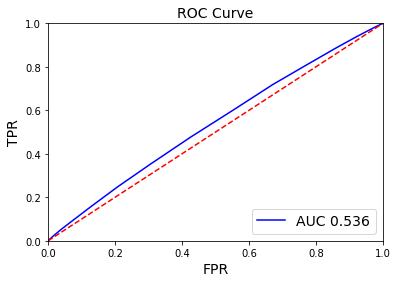

In [24]:
#Calculate ROC curve for NB model
fpr, tpr, thresholds = roc_curve(y_test, y_knn[:,1])
auc = roc_auc_score(y_test, y_knn[:,1])

plt.plot(fpr, tpr, color = 'blue')
plt.plot([0,1], [0,1], color = 'red', linestyle = '--')
plt.xlabel('FPR', fontsize = 14)
plt.ylabel('TPR', fontsize = 14)
plt.title('ROC Curve', fontsize = 14)
plt.axis([0, 1, 0, 1])
plt.legend(['AUC %.3f'%auc], loc = 'lower right', fontsize = 14)
plt.savefig('ROC_XGBClassifier_knn_embed_av.png', bbox = 'tight')
plt.show()

# Random Forest

In [10]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 80)
rf_model = rf.fit(X_train, y_train)

Wall time: 9min 14s


In [11]:
#Collection prediction values for classification
y_rf = rf.predict_proba(X_test)
prediction_rf = [round(value[1]) for value in y_rf]

In [12]:
#Calculate accuracy score for the predictions
accuracy = accuracy_score(y_test, prediction_rf)
print('Accuracy: %.4f'%(accuracy))

Accuracy: 0.5626


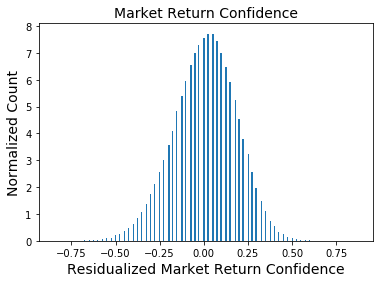

In [32]:
#Plot histogram of prediction results.  Notice, using the Two Sigma scoring metric to calculate the 
#conifidence that returnOpenNextMktres10 is negative or positive.
y_r = y_rf[:,1]*2 - 1
plt.hist(y_r, bins = 'auto', density = True)
plt.xlabel('Residualized Market Return Confidence', fontsize = 14)
plt.ylabel('Normalized Count', fontsize = 14)
plt.title('Market Return Confidence', fontsize = 14)
plt.savefig('ReturnConfidence_rf_embed_av.png', bbox = 'tight')
plt.show()

In [16]:
#Calculate the metric used Two Sigma competition for scoring
y_r = y_rf[:,1]*2 - 1
score_rf = two_sigma_score(y_r, univ_test, r_test)
print('Score using Light Random Forest %.4f'%(score_rf))

Score using Light Random Forest 0.8787


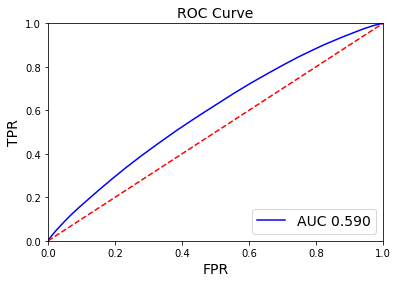

In [33]:
#Calculate ROC curve for NB model
fpr, tpr, thresholds = roc_curve(y_test, y_rf[:,1])
auc = roc_auc_score(y_test, y_rf[:,1])

plt.plot(fpr, tpr, color = 'blue')
plt.plot([0,1], [0,1], color = 'red', linestyle = '--')
plt.xlabel('FPR', fontsize = 14)
plt.ylabel('TPR', fontsize = 14)
plt.title('ROC Curve', fontsize = 14)
plt.axis([0, 1, 0, 1])
plt.legend(['AUC %.3f'%auc], loc = 'lower right', fontsize = 14)
plt.savefig('ROC_XGBClassifier_rf_embed_av.png', bbox = 'tight')
plt.show()

# Ensemble Weighted Average of XGBoost and Random Forest

In [56]:
#Average of the probabilities for xgboost and random forest
y_av = (y_pred[:,1]*54 + y_rf[:,1]*46)/100
predictions_av = [round(value) for value in y_av]

In [52]:

df3 = pd.DataFrame(columns = ('index', 'accuracy', 'score'))

for index in range(100):
    y_av = (y_pred[:,1]*index + y_rf[:,1]*(100-index))/100
    predictions_av = [round(value) for value in y_av]
    accuracy = accuracy_score(y_test, predictions_av)
    y_r = y_av*2 - 1
    score_av = two_sigma_score(y_r, univ_test, r_test)
    df3.loc[index] = [index, accuracy, score_av]

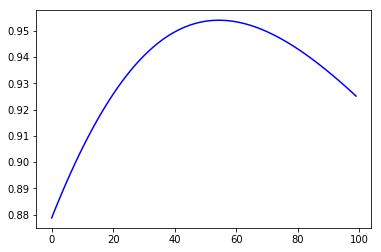

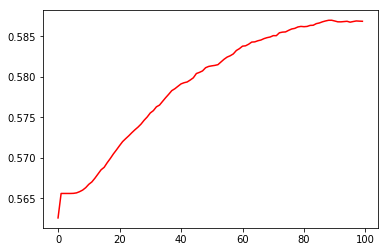

54
89


C:\Users\jjjon\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  """
C:\Users\jjjon\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  


In [55]:
plt.plot(df3.index, df3.score, color = 'blue')
plt.show()
plt.plot(df3.index, df3.accuracy, color = 'red')
plt.show()
print(df3.score.argmax())
print(df3.accuracy.argmax())

In [57]:
#Calculate accuracy score for the predictions
accuracy = accuracy_score(y_test, predictions_av)
print('Accuracy: %.4f'%(accuracy))

Accuracy: 0.5822


In [58]:
y_r = y_av*2 - 1
score_av = two_sigma_score(y_r, univ_test, r_test)
print('Score using Av XGBoost and RF %.4f'%(score_av))

Score using Av XGBoost and RF 0.9541


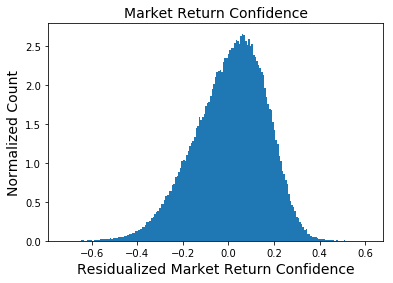

In [59]:
#Plot histogram of prediction results.  Notice, using the Two Sigma scoring metric to calculate the 
#conifidence that returnOpenNextMktres10 is negative or positive.
y_r = y_av*2 - 1
plt.hist(y_r, bins = 'auto', density = True)
plt.xlabel('Residualized Market Return Confidence', fontsize = 14)
plt.ylabel('Normalized Count', fontsize = 14)
plt.title('Market Return Confidence', fontsize = 14)
plt.savefig('ReturnConfidence_WtAv_embed_av.png', bbox = 'tight')
plt.show()

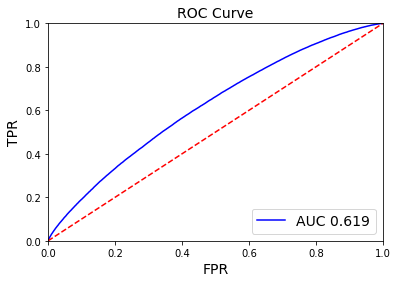

In [60]:
#Calculate ROC curve for NB model
fpr, tpr, thresholds = roc_curve(y_test, y_av)
auc = roc_auc_score(y_test, y_av)

plt.plot(fpr, tpr, color = 'blue')
plt.plot([0,1], [0,1], color = 'red', linestyle = '--')
plt.xlabel('FPR', fontsize = 14)
plt.ylabel('TPR', fontsize = 14)
plt.title('ROC Curve', fontsize = 14)
plt.axis([0, 1, 0, 1])
plt.legend(['AUC %.3f'%auc], loc = 'lower right', fontsize = 14)
plt.savefig('ROC_XGBClassifier_WtAv_embed_av.png', bbox = 'tight')
plt.show()

# Ensemble Stacking Classification

In [11]:
#Produce Instances of model to use in stacking
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingCVClassifier
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

model1 = RandomForestClassifier(n_estimators = 80)
model2 = KNeighborsClassifier(n_neighbors = 30)
model3 = XGBClassifier(**params)
lr = LogisticRegression(solver = 'lbfgs')

smodel = StackingCVClassifier(classifiers = [model1, model2, model3],\
                              use_probas = True,\
                              meta_classifier = lr)

In [40]:
#Calculate cross validation scores using stacking classifier
print('3-fold cross validation score')
for clf, label in zip([model1, model2, model3, smodel], 
                      ['Random Forest', 
                       'KNN', 
                       'XGBoost',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X_train.values, y_train.values, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation score
Accuracy: 0.53 (+/- 0.00) [Random Forest]
Accuracy: 0.52 (+/- 0.00) [KNN]
Accuracy: 0.59 (+/- 0.00) [XGBoost]
Accuracy: 0.59 (+/- 0.00) [StackingClassifier]


In [12]:
#Fit the stacking classifier and evaluate results
stack_fit = smodel.fit(X_train.values, y_train.values)

In [13]:
y_pred_stack = smodel.predict_proba(X_test.values)

prediction_stack = [round(value[1]) for value in y_pred_stack]
#Calculate accuracy score for the predictions
accuracy = accuracy_score(y_test, prediction_stack)
print('Accuracy: %.4f'%(accuracy))

Accuracy: 0.5888


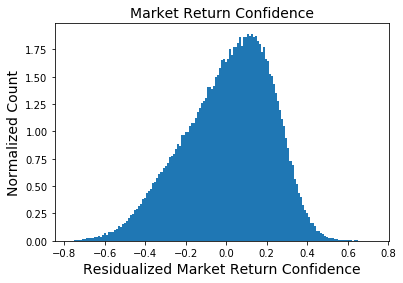

In [14]:
#Plot histogram of prediction results.  Notice, using the Two Sigma scoring metric to calculate the 
#conifidence that returnOpenNextMktres10 is negative or positive.
y_r_stack = y_pred_stack[:,1]*2 - 1
plt.hist(y_r_stack, bins = 'auto', density = True)
plt.xlabel('Residualized Market Return Confidence', fontsize = 14)
plt.ylabel('Normalized Count', fontsize = 14)
plt.title('Market Return Confidence', fontsize = 14)
plt.savefig('ReturnConfidence_Stack_embed.png', bbox = 'tight')
plt.show()

In [15]:
#Calcaulate two sigma score for the stacking models
y_r = y_pred_stack[:,1]*2 - 1
score_stack = two_sigma_score(y_r, univ_test, r_test)
print('Score using Stacking Models %.4f'%(score_stack))

Score using Stacking Models 0.9534


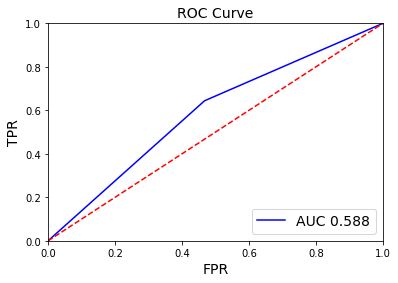

In [16]:
predictions_stack = [round(value) for value in y_pred_stack[:,1]]

#Calculate ROC curve for stack model
fpr, tpr, thresholds = roc_curve(y_test, predictions_stack)
auc = roc_auc_score(y_test, predictions_stack)

plt.plot(fpr, tpr, color = 'blue')
plt.plot([0,1], [0,1], color = 'red', linestyle = '--')
plt.xlabel('FPR', fontsize = 14)
plt.ylabel('TPR', fontsize = 14)
plt.title('ROC Curve', fontsize = 14)
plt.axis([0, 1, 0, 1])
plt.legend(['AUC %.3f'%auc], loc = 'lower right', fontsize = 14)
plt.savefig('ROC_XGBClassifier_stack__embed.png', bbox = 'tight')
plt.show()

# Strengths and Weaknesses Analysis

In [19]:
#y_r
#day_test
#asset_test
y_r = pd.Series(y_r)
weak_y = y_r.abs() < 0.001
print(weak_y.sum())
strong_y = y_r.abs() > 0.63
print(strong_y.sum())

738
567


In [33]:
strong_day = day_test.reset_index(drop = True)[strong_y]
strong_asset = asset_test.reset_index(drop = True)[strong_y]
strong_r = r_test.reset_index(drop = True)[strong_y]
strong_sent = X_test.sentimentClass.reset_index(drop = True)[strong_y]
strong_X = X_test.reset_index(drop = True)[strong_y].mean(axis = 0)

strong_month = pd.Series([vdate.month for vdate in strong_day])
strong_year = pd.Series([vdate.year for vdate in strong_day])

print('Strong r', strong_r.mean())
print('Strong X', strong_X)

df_date = pd.DataFrame()
df_date['year'] = strong_year
df_date['month'] = strong_month
df_date['num'] = pd.Series(np.ones((len(strong_year),)))
print(df_date.groupby(['year', 'month']).sum())

str1 = ''
#Find words in asset names
for index in strong_asset:
    str1 += ' ' + index
str2 = []
str1 = str1.split()
df2 = pd.DataFrame(columns=['word', 'count'])
for index in str1:
    if (index not in str2):
        str2.append(index)
for index in range(len(str2)):
    df2.loc[index] = [str2[index], str1.count(str2[index])]
df2.reset_index(drop = True).sort_values('count', ascending = False)

Strong r -0.07860871922832456
Strong X close                       3.873093e+01
firstMentionSentence        3.738456e+00
headline_0                  7.039938e-01
headline_1                 -2.949013e-01
headline_2                 -3.320404e-02
headline_3                 -1.284600e-03
headline_4                  2.515483e-01
headline_5                 -1.402446e-02
headline_6                 -3.242026e-01
headline_7                  6.987382e-02
headline_8                 -1.365257e-01
headline_9                 -2.717405e-03
index                       4.028872e+06
noveltyCount12H             3.554207e-01
noveltyCount24H             4.378399e-01
noveltyCount3D              6.462961e-01
noveltyCount5D              8.089249e-01
noveltyCount7D              1.035503e+00
open                        3.880395e+01
relevance                   7.554015e-01
returnsClosePrevMktres1    -1.757485e-03
returnsClosePrevMktres10   -5.257510e-02
returnsClosePrevRaw1       -2.144627e-03
returnsClosePrevRa

,word,count
2,Inc,180
22,Corp,152
59,Energy,83
16,Ltd,76
7,SA,47
37,Co,46
19,Resources,41
26,PLC,40
13,Gold,33
28,Group,30


In [31]:
weak_day = day_test.reset_index(drop = True)[weak_y]
weak_asset = asset_test.reset_index(drop = True)[weak_y]
weak_r = r_test.reset_index(drop = True)[weak_y]
weak_sent = X_test.sentimentClass.reset_index(drop = True)[weak_y]
weak_X = X_test.reset_index(drop = True)[weak_y].mean(axis = 0)

weak_month = pd.Series([vdate.month for vdate in weak_day])
weak_year = pd.Series([vdate.year for vdate in weak_day])

print('Weak r', weak_r.mean())
print('Weak X', weak_X)

df_date = pd.DataFrame()
df_date['year'] = weak_year
df_date['month'] = weak_month
df_date['num'] = pd.Series(np.ones((len(weak_year),)))
print(df_date.groupby(['year', 'month']).sum())

str1 = ''
#Find words in asset names
for index in weak_asset:
    str1 += ' ' + index
str2 = []
str1 = str1.split()
df2 = pd.DataFrame(columns=['word', 'count'])
for index in str1:
    if (index not in str2):
        str2.append(index)
for index in range(len(str2)):
    df2.loc[index] = [str2[index], str1.count(str2[index])]
df2.sort_values('count', ascending = False)

Weak r 0.002841864134169144
Weak X close                       4.905297e+01
firstMentionSentence        5.476650e+00
headline_0                  5.979899e-01
headline_1                  8.268080e-02
headline_2                 -1.705839e-01
headline_3                 -8.377827e-02
headline_4                  3.472809e-02
headline_5                  1.197617e-01
headline_6                 -2.507328e-02
headline_7                 -5.864270e-02
headline_8                 -2.986290e-02
headline_9                 -1.533463e-02
index                       3.461366e+06
noveltyCount12H             4.421111e-01
noveltyCount24H             5.023193e-01
noveltyCount3D              6.553651e-01
noveltyCount5D              7.198677e-01
noveltyCount7D              8.850752e-01
open                        4.903899e+01
relevance                   7.281573e-01
returnsClosePrevMktres1    -4.248453e-04
returnsClosePrevMktres10   -4.994525e-03
returnsClosePrevRaw1       -2.570993e-04
returnsClosePrevRaw10 

,word,count
8,Inc,352
1,Corp,187
54,Group,51
20,Co,49
5,Ltd,48
226,Financial,32
98,Holdings,26
64,&,24
50,PLC,24
110,SA,21


2015-12-18 Chesapeake Energy Corp


C:\Users\jjjon\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.
  import sys


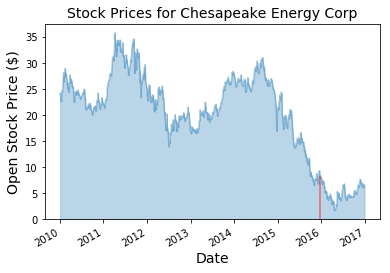

In [22]:
max_index = y_r.abs().idxmax()
max_date = day_test.iloc[max_index]
max_asset = asset_test.iloc[max_index]

print(max_date, max_asset)
y_max = data[(data.assetName == max_asset) &
             (data.time == max_date)].open

x = data[data.assetName == max_asset].time
y = data[data.assetName == max_asset].set_index('time').open

y.plot.area(alpha = .3)
plt.plot([max_date, max_date], [0, y_max], color = 'red', alpha = .5)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Open Stock Price ($)', fontsize = 14)
plt.title('Stock Prices for '+max_asset, fontsize = 14)
plt.savefig('Open_Strong.png', bbox = 'tight')
plt.show()

In [52]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

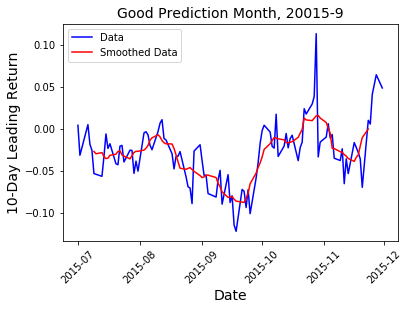

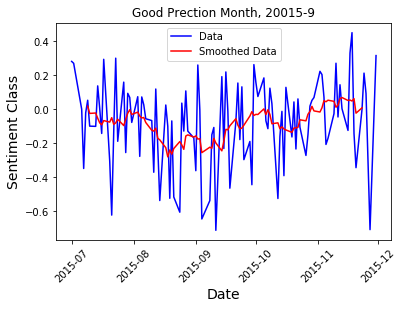

In [83]:
asset_cond = [("Energy" in value) or ("Oil" in value) or ("Petroleum" in value) for value in data.assetName]

x = data[asset_cond & (data.time.dt.year == 2015) & \
         (data.time.dt.month >= 7) & (data.time.dt.month <= 11)].time
y = data[asset_cond & (data.time.dt.year == 2015) & \
         (data.time.dt.month >= 7) & (data.time.dt.month <= 11)].returnsOpenNextMktres10
df = pd.DataFrame()
df['x'] = x
df['y'] = y
df = df.groupby('x').mean()
df = df.reset_index(drop = False)

plt.plot(df.x, df.y, color = 'blue')
plt.plot(df.x[5:len(df.x)-4], smooth(df.y,10)[5:len(df.y)-4], color = 'red')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('10-Day Leading Return', fontsize = 14)
plt.title('Good Prediction Month, 20015-9', fontsize = 14)
plt.legend(['Data', 'Smoothed Data'])
plt.xticks(rotation = 45)
plt.savefig('Good_Pred_Month.png', bbox_inches = 'tight')
plt.show()

y = data[asset_cond & (data.time.dt.year == 2015) & \
         (data.time.dt.month >= 7) & (data.time.dt.month <= 11)].sentimentClass
df = pd.DataFrame()
df['x'] = x
df['y'] = y
df = df.groupby('x').mean()
df = df.reset_index(drop = False)

plt.plot(df.x, df.y, color = 'blue')
plt.plot(df.x[5:len(df.x)-4], smooth(df.y,10)[5:len(df.y)-4], color = 'red')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Sentiment Class', fontsize = 14)
plt.title('Good Prection Month, 20015-9')
plt.legend(['Data', 'Smoothed Data'])
plt.xticks(rotation = 45)
plt.savefig('Good_Pred_Month_Sent.png', bbox_inches = 'tight')
plt.show()

2011-08-09 Cepheid


C:\Users\jjjon\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.
  import sys


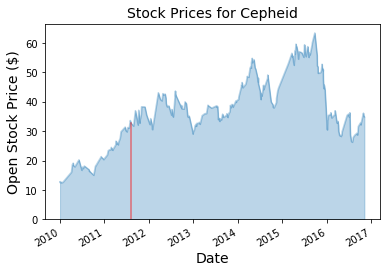

In [25]:
min_index = y_r.abs().idxmin()
min_date = day_test.iloc[min_index]
min_asset = asset_test.iloc[min_index]

print(min_date, min_asset)
y_min = data[(data.assetName == min_asset) &
             (data.time == min_date)].open

x = data[data.assetName == min_asset].time
y = data[data.assetName == min_asset].set_index('time').open

y.plot.area(alpha = 0.3)
plt.plot([min_date, min_date], [0, y_min], color = 'red', alpha = .5)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Open Stock Price ($)', fontsize = 14)
plt.title('Stock Prices for '+min_asset, fontsize = 14)
plt.savefig('Open_Weak.png', bbox = 'tight')
plt.show()